In [1]:
cd ..

/home/wesg/research/ordinal-probing


In [2]:
# autoreload
%load_ext autoreload
%autoreload 2

import numpy as np
import sklearn
import pandas as pd
import matplotlib.pyplot as plt
import torch
from scipy.stats import rankdata
from load import load_model
import datasets
import seaborn as sns

from feature_datasets.common import *
import utils
import os

from save_activations import load_activation_probing_dataset
from probe_experiment import load_probe_results
from analysis.generalization import*
from analysis.probe_plots import *

from sklearn.decomposition import PCA


%matplotlib inline

In [17]:
experiment_name = 'full_prompt'

MODEL_LAYER = {
    'Llama-2-7b-hf': 20,
    'Llama-2-13b-hf': 24,
    'Llama-2-70b-hf': 48,
}
models = ['Llama-2-7b-hf', 'Llama-2-13b-hf', 'Llama-2-70b-hf']

trial_info = {
    'World Map': ('world_place', 'coords', 'coords'),
    'USA Map': ('us_place', 'coords', 'coords'),
    'Historical': ('historical_figure', 'death_year', 'when'),
    'Entertainment': ('art', 'release_date', 'release'),
    'Headlines': ('headline', 'pub_date', 'empty'),
    'NYC Map': ('nyc_place', 'coords', 'where_nyc'),
}

In [18]:
pca_probe_results = {}
for model in models:
    for dataset in trial_info:
        entity_name, feature_name, prompt_name, = trial_info[dataset]
        probe_result = load_probe_results(experiment_name, model, entity_name, feature_name, prompt_name, pca=True)
        pca_probe_results[(model, dataset)] = probe_result

In [19]:
def make_pca_result_df_dict(models, trial_info, experiment_name):
    rdf_dict = {}
    for name, trial in trial_info.items():
        entity_type, feature_name, prompt = trial
        trial_rdfs = {}
        for model in models:
            probe_result = load_probe_results(
                experiment_name, model, entity_type, feature_name, prompt, pca=True)
            rdf = pd.DataFrame(probe_result['scores']).T
            rdf.index.name = 'k'
            trial_rdfs[model] = rdf
            
        trial_rdf = pd.concat(trial_rdfs, names=['model'])
        trial_rdf.columns = trial_rdf.columns.map('_'.join)
        trial_rdf = trial_rdf.reset_index()
        rdf_dict[name] = trial_rdf
    return rdf_dict


# increase text size
def main_plot_performance_by_layer(rdf_dict, metric='test_r2', metric_label='test $R^2$', fontsize=11, normalize_layer=True, save_name=''):
    plt.rcParams.update({'font.size': fontsize})
    fig, axs = plt.subplots(2, 3, figsize=(10, 5), sharex=True)
    for i, (name, trial) in enumerate(trial_info.items()):
        entity_type, feature_name, prompt = trial
        rdf = rdf_dict[name]
        ax = axs[i//3, i%3]
        for model in models:
            data_df = rdf[rdf.model == model]
            layer = data_df.layer.values
            if normalize_layer:
                layer = layer / layer.max()
            ax.plot(layer, data_df[metric].values, label=model)
        ax.set_title(name)
        if i == 0:
            ax.legend(title='Model', loc='lower right', labels=[m[:-3] for m in models])
        ax.grid(alpha=0.5, linestyle='--')
        if i % 3 == 0:
            ax.set_ylabel(metric_label)
        if i // 3 == 1:
            ax.set_xlabel('model depth')

        # turn off top and bottom splines
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
    plt.tight_layout()

    if save_name:
        plt.savefig(os.path.join('figures', save_name))
        
    return fig, axs

In [20]:
rdf_dict = make_pca_result_df_dict(models, trial_info, experiment_name)

In [21]:
rdf_dict['World Map'].head()

,model,k,train_x_r2,train_y_r2,train_r2,train_x_mae,train_y_mae,train_mae,train_mse,train_rmse,...,test_y_spearman,test_y_spearman_p,test_y_kendall,test_y_kendall_p,test_haversine_mse,test_haversine_rmse,test_haversine_mae,test_haversine_r2,train_prox_error,test_prox_error
0,Llama-2-7b-hf,2,0.044401,0.002392,0.023396,61.618686,22.770259,42.194473,3311.077738,57.541965,...,0.114973,1.039966e-24,0.072304,5.019391e-22,6.608997e+07,8129.574034,7109.034004,0.061991,0.466487,0.464867
1,Llama-2-7b-hf,4,0.130670,0.027572,0.079121,55.082106,22.166199,38.624152,3038.283897,55.120630,...,0.229961,1.619371e-95,0.152053,1.605757e-91,5.687372e+07,7541.466925,6329.024476,0.192797,0.360789,0.362753
2,Llama-2-7b-hf,6,0.268369,0.161219,0.214794,51.392065,20.155170,35.773617,2565.238055,50.648179,...,0.516738,0.000000e+00,0.348274,0.000000e+00,5.111566e+07,7149.521970,5870.777094,0.274520,0.322317,0.321521
3,Llama-2-7b-hf,8,0.296575,0.234288,0.265432,50.568348,19.171323,34.869836,2449.942334,49.496892,...,0.596608,0.000000e+00,0.410849,0.000000e+00,4.964425e+07,7045.867381,5764.582955,0.295404,0.298509,0.299372
4,Llama-2-7b-hf,10,0.393517,0.488452,0.440985,47.816743,15.565815,31.691279,2052.457361,45.304055,...,0.680666,0.000000e+00,0.485967,0.000000e+00,4.539581e+07,6737.641085,5513.942215,0.355702,0.278082,0.280415


In [9]:
plt.rcParams.update({'font.size': 11})

In [25]:
from matplotlib.lines import Line2D
def main_pca_plot_performance_by_dimension(rdf_dict, metric='test_r2', metric_label='test $R^2$', fontsize=12, save_name=''):
    # change fontsize to 11
    plt.rcParams.update({'font.size': fontsize})
    colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown']
    fig, axs = plt.subplots(1, 3, figsize=(12, 4), sharey=True)
    for ix, model in enumerate(models):
        ax = axs[ix]
        for jx, dataset in enumerate(trial_info):
            if dataset == 'NYC Map':
                continue
            rdf = rdf_dict[dataset]
            data_df = rdf[rdf.model == model]
            if metric == 'test_spearman' and dataset.endswith('Map'):
                metric_values = data_df[['test_x_spearman', 'test_y_spearman']].values.mean(axis=1)
            else:
                metric_values = data_df[metric].values
            pca_dims = data_df.k.values
            ax.plot(pca_dims[:-1], metric_values[:-1], label=dataset, color=colors[jx])
            # horizontal line at values for full PCA
            ax.axhline(metric_values[-1], linestyle='--', color=colors[jx])
        ax.set_title(model[:-3])
        ax.set_xscale('log')
        ax.set_ylim(bottom=0)
        ax.grid(alpha=0.5, linestyle='--')
        ax.set_xlabel('PCA dimensions')
        if ix == 0:
            ax.set_ylabel(metric_label)

        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        
    legend_line = Line2D([0], [0], color='black', linestyle='--', lw=1, label='full dimension')

    # Get the existing handles and labels from the legend on axs[2]
    handles, labels = axs[2].get_legend_handles_labels()
    # Append the custom legend entry
    handles.append(legend_line)
    labels.append('full dimension')
    # Reapply the legend with the additional entry
    axs[2].legend(handles=handles, labels=labels, title='Dataset', fontsize=11)

    plt.tight_layout()

    if save_name:
        plt.savefig(os.path.join('figures', save_name), bbox_inches='tight')
        
    return fig, axs

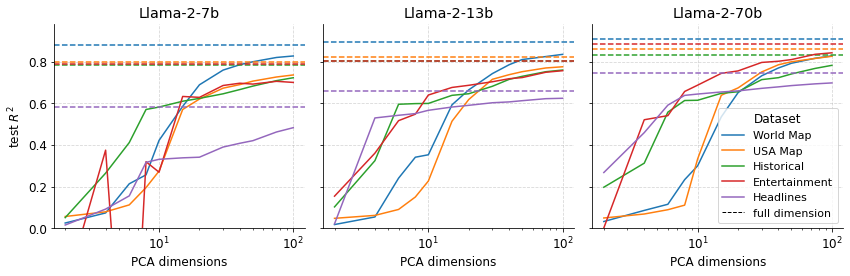

In [26]:
main_pca_plot_performance_by_dimension(rdf_dict, save_name='pca_probe_perf.png');

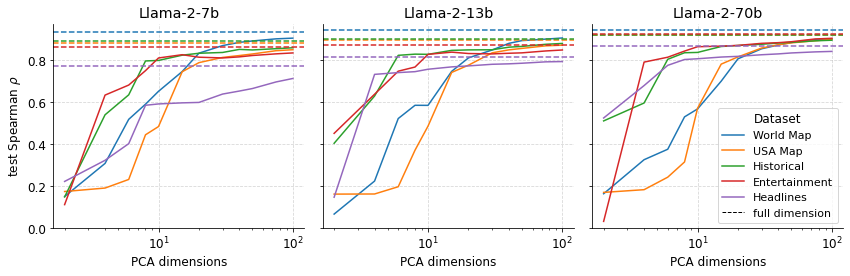

In [27]:
main_pca_plot_performance_by_dimension(rdf_dict, metric='test_spearman', metric_label='test Spearman $\\rho$', save_name='pca_probe_spearman_perf.png');

In [37]:
alpha_dict = {}
for k, v in pca_probe_results.items():
    for layer, alpha_array in v['probe_alphas'].items():
        alpha_dict[k + (layer, )] = alpha_array

alpha_df = pd.DataFrame(alpha_dict).T
alpha_df.index.names = ['model', 'entity_type', 'pca_dim']

alpha_df['argmin'] = alpha_df.apply(lambda x: x.argmin(), axis=1)

#pandas display 200 rows
pd.set_option('display.max_rows', 200)
alpha_df.groupby(['model', 'pca_dim'])['argmin'].describe()#.head()

count       mean       std  min    25%   50%    75%  \
model          pca_dim                                                        
Llama-2-13b-hf 2          6.0   9.666667  1.632993  7.0   9.00  10.0  11.00   
               4          6.0   8.000000  2.366432  5.0   6.25   8.0   9.75   
               6          6.0   7.333333  2.581989  5.0   5.25   6.5   9.25   
               8          6.0   7.166667  2.041241  6.0   6.00   6.0   7.50   
               10         6.0   7.166667  2.041241  5.0   6.25   7.0   7.00   
               15         6.0   7.000000  2.097618  5.0   6.00   6.5   7.00   
               20         6.0   7.166667  2.136976  5.0   6.00   6.5   7.75   
               30         6.0   7.166667  1.722401  5.0   6.25   7.0   7.75   
               40         6.0   7.500000  1.643168  6.0   6.25   7.0   8.50   
               50         6.0   7.500000  1.643168  6.0   6.25   7.0   8.50   
               75         6.0   7.500000  1.224745  6.0   7.00   7.0   8.50   
               100        6.0   7.833333  0.983192  7.0   7.00   7.5   8.75   
               5120       6.0   8.833333  0.408248  8.0   9.00   9.0   9.00   
Llama-2-70b-hf 2          6.0  10.000000  1.264911  8.0   9.25  10.5  11.00   
               4          6.0   9.000000  2.097618  6.0   7.50   9.5  10.75   
               6          6.0   8.833333  2.041241  7.0   7.00   8.5  10.75   
               8          6.0   8.500000  1.760682  7.0   7.00   8.0   9.75   
               10         6.0   8.166667  1.471960  7.0   7.25   8.0   8.00   
               15         6.0   8.000000  1.788854  6.0   7.00   7.5   8.75   
               20         6.0   8.166667  1.722401  6.0   7.25   8.0   8.75   
               30         6.0   8.333333  1.505545  7.0   7.25   8.0   8.75   
               40         6.0   8.333333  1.366260  7.0   7.25   8.0   9.50   
               50         6.0   8.333333  1.366260  7.0   7.25   8.0   9.50   
               75         6.0   8.666667  1.032796  8.0   8.00   8.0   9.50   
               100        6.0   8.833333  0.983192  8.0   8.00   8.5   9.75   
               8192       6.0   9.833333  0.408248  9.0  10.00  10.0  10.00   
Llama-2-7b-hf  2          6.0   9.000000  1.095445  8.0   8.25   9.0   9.00   
               4          6.0   7.833333  2.041241  5.0   7.00   7.5   8.75   
               6          6.0   6.666667  2.422120  5.0   5.00   5.5   7.50   
               8          6.0   6.333333  2.503331  4.0   5.00   5.5   6.75   
               10         6.0   5.833333  2.562551  4.0   5.00   5.0   5.00   
               15         6.0   6.000000  2.529822  4.0   5.00   5.0   5.75   
               20         6.0   6.166667  2.483277  4.0   5.00   5.5   6.00   
               30         6.0   6.166667  1.940790  5.0   5.00   5.5   6.00   
               40         6.0   6.166667  1.940790  5.0   5.00   5.5   6.00   
               50         6.0   6.333333  1.366260  5.0   6.00   6.0   6.00   
               75         6.0   6.500000  1.378405  5.0   6.00   6.0   6.75   
               100        6.0   6.833333  1.329160  5.0   6.25   7.0   7.00   
               4096       6.0   7.666667  1.032796  6.0   7.25   8.0   8.00   

                         max  
model          pca_dim        
Llama-2-13b-hf 2        11.0  
               4        11.0  
               6        11.0  
               8        11.0  
               10       11.0  
               15       11.0  
               20       11.0  
               30       10.0  
               40       10.0  
               50       10.0  
               75        9.0  
               100       9.0  
               5120      9.0  
Llama-2-70b-hf 2        11.0  
               4        11.0  
               6        11.0  
               8        11.0  
               10       11.0  
               15       11.0  
               20       11.0  
               30       11.0  
               40       10.0  
               50       10.0  
         

In [36]:
alpha_df

0         1         2         3  \
Llama-2-7b-hf  World Map 2     0.976775  0.976775  0.976775  0.976775   
                         4     0.921136  0.921136  0.921136  0.921136   
                         6     0.785519  0.785519  0.785519  0.785519   
                         8     0.734957  0.734957  0.734957  0.734957   
                         10    0.559378  0.559378  0.559378  0.559378   
...                                 ...       ...       ...       ...   
Llama-2-70b-hf Headlines 40    0.328215  0.328215  0.328215  0.328215   
                         50    0.322841  0.322841  0.322841  0.322841   
                         75    0.314429  0.314429  0.314429  0.314429   
                         100   0.308935  0.308935  0.308935  0.308935   
                         8192  0.384994  0.383466  0.380288  0.373973   

                                      4         5         6         7  \
Llama-2-7b-hf  World Map 2     0.976775  0.976775  0.976775  0.976775   
                         4     0.921136  0.921136  0.921136  0.921136   
                         6     0.785519  0.785519  0.785519  0.785519   
                         8     0.734957  0.734957  0.734957  0.734957   
                         10    0.559378  0.559377  0.559377  0.559378   
...                                 ...       ...       ...       ...   
Llama-2-70b-hf Headlines 40    0.328214  0.328214  0.328214  0.328214   
                         50    0.322841  0.322841  0.322841  0.322840   
                         75    0.314429  0.314428  0.314428  0.314426   
                         100   0.308935  0.308934  0.308933  0.308930   
                         8192  0.362453  0.344263  0.320851  0.297061   

                                      8         9        10        11  argmin  
Llama-2-7b-hf  World Map 2     0.976775  0.976775  0.976775  0.976775       9  
                         4     0.921136  0.921136  0.921137  0.921139       8  
                         6     0.785519  0.785520  0.785525  0.785543       6  
                         8     0.734957  0.734959  0.734965  0.734993       7  
                         10    0.559379  0.559382  0.559399  0.559467       5  
...                                 ...       ...       ...       ...     ...  
Llama-2-70b-hf Headlines 40    0.328213  0.328211  0.328211  0.328220      10  
                         50    0.322839  0.322836  0.322834  0.322844      10  
                         75    0.314423  0.314417  0.314410  0.314420      10  
                         100   0.308924  0.308913  0.308899  0.308908      10  
                         8192  0.277905  0.265733  0.260516  0.261174      10  

[234 rows x 13 columns]

In [3]:


activations = {}
for name, (entity_type, prompt_name) in ACTIVATION_CONFIGS.items():
    for model, layer in MODEL_LAYER.items():
        activations[(name, model)] = load_activation_probing_dataset(
            model, entity_type, prompt_name, layer).dequantize()
        break
    break

In [4]:
activation_evrs = {}
for k, activation in activations.items():
    print(k)
    pca = PCA()
    pca.fit(activation.numpy())
    activation_evrs[k] = pca.explained_variance_ratio_

('World Map', 'Llama-2-7b-hf')


In [7]:
pca.components_.shape

(4096, 4096)

In [11]:
np.logspace(0.8, 4.1, 12).astype(int)

array([    6,    12,    25,    50,   100,   199,   398,   794,  1584,
        3162,  6309, 12589])

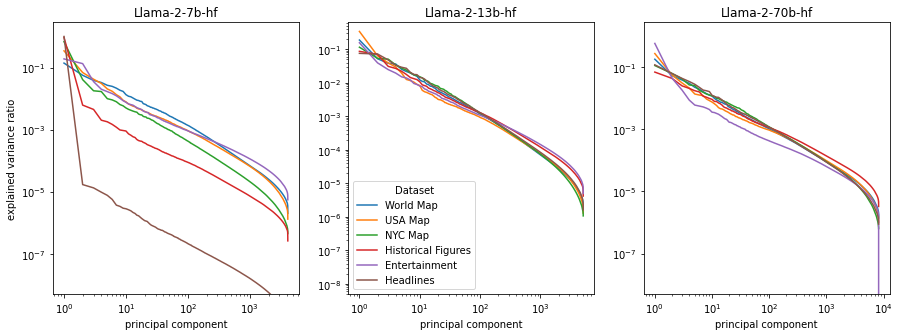

In [16]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
for i, model in enumerate(MODEL_LAYER.keys()):
    for name in ACTIVATION_CONFIGS:
        evrs = activation_evrs[(name, model)]
        axs[i].plot(np.arange(1, len(evrs)+1), evrs, label=name)
    axs[i].set_title(model)
    axs[i].set_yscale('log')
    axs[i].set_xscale('log')
    axs[i].set_xlabel('principal component')
    axs[i].set_ylim(bottom=5e-9)

axs[0].set_ylabel('explained variance ratio')
axs[1].legend(title='Dataset')
plt.show()

In [12]:
activation_evrs[('Headlines', 'Llama-2-7b-hf')]

array([9.9982387e-01, 1.6828533e-05, 1.3167459e-05, ..., 6.5263966e-10,
       6.2012906e-10, 6.1229521e-10], dtype=float32)

In [13]:
activation_evrs[('Headlines', 'Llama-2-7b-hf')]

array([9.3583816e-01, 6.1385301e-03, 4.4498187e-03, ..., 3.4772791e-07,
       2.8524792e-07, 2.5804354e-07], dtype=float32)

In [37]:
acts = activations[('Headlines', 'Llama-2-7b-hf')]

(array([4.094e+03, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([1.6355790e-01, 8.9906540e+01, 1.7964952e+02, 2.6939252e+02,
        3.5913550e+02, 4.4887848e+02, 5.3862146e+02, 6.2836444e+02,
        7.1810742e+02, 8.0785040e+02, 8.9759338e+02], dtype=float32),
 <BarContainer object of 10 artists>)

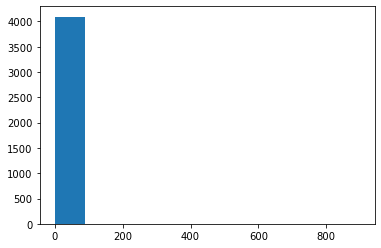

In [39]:
plt.hist(acts.std(axis=0).numpy())

In [40]:
acts.std(axis=0).numpy().argmax()

2533

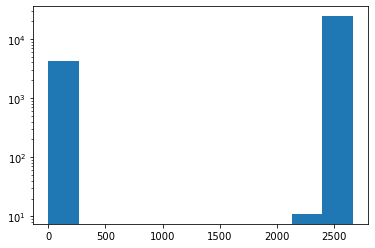

In [46]:
plt.hist(acts[:, 2533].numpy())
#plt.yscale('log')

(array([4.1620e+03, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 1.1000e+01, 2.4216e+04]),
 array([ 0.68524927,  5.45562   , 10.22599   , 14.996361  , 19.766731  ,
        24.537102  , 29.307472  , 34.077843  , 38.848213  , 43.618584  ,
        48.388954  ], dtype=float32),
 <BarContainer object of 10 artists>)

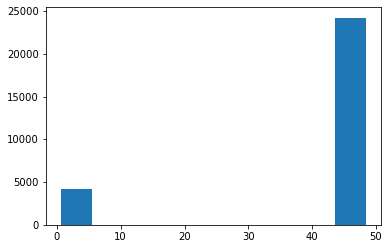

In [25]:
plt.hist(activations[('Headlines', 'Llama-2-7b-hf')].std(axis=1).numpy())

In [28]:
edf = load_entity_data('headline')

In [36]:
edf.iloc[activations[('Headlines', 'Llama-2-7b-hf')].std(axis=1).numpy() > 20].headline.values

array(['Bomb Takes Heavy Toll at Pakistan Sports Event.',
       'Standoff in Iran Deepens With New Show of Force.',
       'Different Taliban Groups Claim Role in Afghanistan Bombing.', ...,
       'Phil Niekro, Hall of Fame Knuckleball Pitcher, Dies at 81.',
       'Pierre Cardin, Designer to the Famous and Merchant to the Masses, Dies at 98.',
       'Dawn Wells, Mary Ann on ‘Gilligan’s Island,’ Dies at 82.'],
      dtype=object)

In [52]:
edf.iloc[np.abs(acts[:, 2533].numpy()) > 500].headline.values[:20]

array(['Bomb Takes Heavy Toll at Pakistan Sports Event.',
       'Standoff in Iran Deepens With New Show of Force.',
       'Different Taliban Groups Claim Role in Afghanistan Bombing.',
       'Fragile Calm Holds in Darfur After Years of Death.',
       'In Russia, a New Year and a New Price for Vodka.',
       'Many Karzai Afghan Cabinet Choices Are Rejected.',
       'Cartoonist in Denmark Calls Attack ‘Really Close’.',
       'Yemen’s Chaos Aids the Evolution of a Qaeda Cell.',
       'For Shanghai Fair, Famous Fund-Raiser Delivers.',
       'Threats Led to Embassy Closings in Yemen, Officials Say.',
       'Iraq Says Deal Is Near on the Last of 5 Hostages.',
       'Americans’ Role Seen in Uganda Anti-Gay Push.',
       'Hazaras Hustle to Head of Class in Afghanistan.',
       'Iranian Filmmakers Keep Focus on the Turmoil.',
       '4 Afghan War Veterans Look Back, and Ahead.',
       'Leader of Junta Confirms Myanmar Is Planning 2010 Elections.',
       'Standoff Builds Over Afgh